In [62]:
import pykitti
import b3d
import os
import jax.numpy as jnp
import matplotlib.pyplot as plt
from tqdm import tqdm
import genjax
from b3d import Mesh, Pose
import rerun as rr
import jax
from genjax import Pytree
from tqdm import tqdm
b3d.rr_init("kitti")

In [2]:
kitti_data_path = b3d.get_assets_path() / "shared_data_bucket/foundation_pose_tracking_datasets/kitti_initial_data.npz"
kitti_mesh_path = b3d.get_assets_path() / "shared_data_bucket/foundation_pose_tracking_datasets/kitti_initial_data.obj"
data = jnp.load(kitti_data_path)
mesh = b3d.Mesh.from_obj(kitti_mesh_path)

In [3]:
key = jax.random.PRNGKey(0)

In [4]:
import b3d.chisight.dense.likelihoods.image_likelihood
import b3d.chisight.dense.likelihoods.simple_likelihood
intermediate_likelihood_func = b3d.chisight.dense.likelihoods.simple_likelihood.simple_likelihood
image_likelihood = b3d.chisight.dense.likelihoods.image_likelihood.make_image_likelihood(
    intermediate_likelihood_func,
)

In [5]:
height, width = data["rgb"][0].shape[:2]
fx,fy,cx,cy,near,far = data["camera_intrinsics"]
scaling_factor = 0.3
renderer = b3d.renderer.renderer_original.RendererOriginal(
    width * scaling_factor, height * scaling_factor, fx * scaling_factor, fy * scaling_factor, cx * scaling_factor, cy * scaling_factor, 0.01, 2.0
)

In [6]:
rgbd = jnp.concatenate([data["rgb"], data["depths"][...,None]], axis=-1)

In [49]:
from b3d.modeling_utils import uniform_discrete, uniform_pose, gaussian_vmf
@genjax.gen
def dense_model(args_dict):
    meshes = args_dict["meshes"]
    likelihood_args = args_dict["likelihood_args"]
    object_pose = uniform_pose(jnp.ones(3)*-100.0, jnp.ones(3)*100.0) @ f"object_pose_0"
    all_poses = Pose.stack_poses([object_pose])

    scene_mesh = Mesh.transform_and_merge_meshes(meshes, all_poses)
    latent_rgbd = renderer.render_rgbd_from_mesh(scene_mesh)
    image = image_likelihood(latent_rgbd, likelihood_args) @ "image"
    return {"scene_mesh": scene_mesh, "latent_rgbd": latent_rgbd, "image": image}

def viz_trace(trace, t=0):
    rr.set_time_sequence("time", t)

    intermediate_info = intermediate_likelihood_func(
        trace.get_choices()["image"],
        trace.get_retval()["latent_rgbd"], 
        trace.get_args()[0]["likelihood_args"]
    )

    rr.log("rgb", rr.Image(trace.get_choices()["image"][...,:3]))
    rr.log("rgb/depth/observed", rr.DepthImage(trace.get_choices()["image"][...,3]))
    rr.log("rgb/depth/latent", rr.DepthImage(trace.get_retval()["latent_rgbd"][...,3]))
    rr.log("rgb/latent", rr.Image(trace.get_retval()["latent_rgbd"][...,:3]))
    rr.log("rgb/is_match", rr.DepthImage(intermediate_info["is_match"] * 1.0))
    rr.log("rgb/color_match", rr.DepthImage(intermediate_info["color_match"] * 1.0))

importance_jit = jax.jit(dense_model.importance)

choicemap = genjax.ChoiceMap.d(
    dict(
        [
            ("object_pose_0",  Pose(data["object_position"][0], data["object_quaternion"][0])),
            ("image", 
                b3d.utils.resize_image(
                    rgbd[0], renderer.height, renderer.width
                )
            )
        ]
    )
)


likelihood_args= {
    "inlier_score": 20.0,
    "color_tolerance": 20.0,
    "depth_tolerance": 1.2,
    "outlier_prob": 0.000001,
    "multiplier": 10000.0,
    "bounds": jnp.array([110.0, 45.0, 45.0, 0.2]),
    "variances" : jnp.zeros(4),
    "fx": renderer.fx,
    "fy": renderer.fy,
    "far": renderer.far,
}


In [48]:
trace, _ = importance_jit(
    jax.random.PRNGKey(2),
    choicemap,
    ({"meshes": [mesh], "likelihood_args": likelihood_args},),
)
print(trace.get_score())
viz_trace(trace, 0)

11199.132


In [50]:
t = 1
trace = b3d.update_choices_jit(trace, jax.random.PRNGKey(0), Pytree.const(("image",)),
    b3d.utils.resize_image(rgbd[t], renderer.height, renderer.width),
)
viz_trace(trace,t)

In [61]:
trace, key = b3d.bayes3d.enumerative_proposals.gvmf_and_select_best_move(
    trace, key, 1.0, 700.0, "object_pose_0", 700
)
trace, key = b3d.bayes3d.enumerative_proposals.gvmf_and_select_best_move(
    trace, key, 0.5, 1000.0, "object_pose_0", 700
)
trace, key = b3d.bayes3d.enumerative_proposals.gvmf_and_select_best_move(
    trace, key, 0.1, 2000.0, "object_pose_0", 700
)
print(trace.get_score())
viz_trace(trace,t)

10318.408


In [65]:
trace, _ = importance_jit(
    jax.random.PRNGKey(2),
    choicemap,
    ({"meshes": [mesh], "likelihood_args": likelihood_args},),
)
print(trace.get_score())
viz_trace(trace, 0)
for t in range(0,len(rgbd)):
    trace = b3d.update_choices_jit(trace, jax.random.PRNGKey(0), Pytree.const(("image",)),
        b3d.utils.resize_image(rgbd[t], renderer.height, renderer.width),
    )
    trace, key = b3d.bayes3d.enumerative_proposals.gvmf_and_select_best_move(
        trace, key, 1.0, 700.0, "object_pose_0", 700
    )
    trace, key = b3d.bayes3d.enumerative_proposals.gvmf_and_select_best_move(
        trace, key, 0.5, 1000.0, "object_pose_0", 700
    )
    trace, key = b3d.bayes3d.enumerative_proposals.gvmf_and_select_best_move(
        trace, key, 0.1, 2000.0, "object_pose_0", 700
    )
    print(trace.get_score())
    viz_trace(trace,t)

13969.692
16875.416
12323.427
13503.892
11741.788
13965.926
12113.416
4425.032
6418.929
4038.6338
14941.854


In [ ]:
[
    b3d.viz_rgb(trace.get_chioces()["image"]),
    b3d.viz_depth(trace.get_retval()["latent_rgbd"]),
    b3d.overlay_image(
        b3d.viz_rgb(trace.get_chioces()["image"]),
        b3d.viz_depth(trace.get_retval()["latent_rgbd"]),
    )
]
for trace in traces

In [3]:

basedir = os.path.join(b3d.get_assets_path(), "kitti")
date = '2011_09_26'
drive = '0005'
frames = range(0, 50, 5)
dataset = pykitti.raw(basedir, date, drive, frames=frames)


In [4]:
data = {}
K = dataset.calib.K_cam0
fx,fy,cx,cy = K[0,0], K[1,1], K[0,2], K[1,2]
rgb = jnp.array(dataset.get_rgb(0)[0])
print(rgb.shape)
height,width = rgb.shape[:2]
data["camera_intrinsics"] = (fx,fy,cx,cy, 0.001, 100.0)
data["image_size"] = (height,width)

rgbs = []
depths = []
for (t,f) in tqdm(enumerate(frames)):
    rgb = jnp.array(dataset.get_rgb(t)[0])
    rgbs.append(rgb)


    velo = dataset.get_velo(t)[:, jnp.array([1, 2, 0])] * jnp.array([-1., -1., 1.])
    b3d.rr.log("velo", b3d.rr.Points3D(velo[...,:3]))

    pixels = b3d.xyz_to_pixel_coordinates(velo[:, :3], fx, fy, cx, cy).astype(jnp.int32)
    depth_image = jnp.zeros((height,width))

    valid_pixels = (
        (0 <= pixels[:, 0])
        * (0 <= pixels[:, 1])
        * (pixels[:, 0] < height)
        * (pixels[:, 1] < width)
        * (velo[:, 2] > 0.0)
    )
    depth_image = depth_image.at[pixels[valid_pixels, 0], pixels[valid_pixels, 1]].set(velo[valid_pixels, 2])
    depths.append(depth_image)

(375, 1242, 3)


0it [00:00, ?it/s]

10it [00:08,  1.23it/s]


In [5]:
for t in range(len(rgbs)):
    b3d.rr.set_time_sequence("time", t)
    b3d.rr.log("rgb", b3d.rr.Image(rgbs[t]))
    b3d.rr.log("depth", b3d.rr.DepthImage(depths[t]))

In [6]:
!wget -q \
'https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth'

/opt/conda/envs/b3d/lib/python3.12/pty.py:95: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


^C


In [7]:
from segment_anything import SamAutomaticMaskGenerator, sam_model_registry
sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

Sam(
  (image_encoder): ImageEncoderViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 1280, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks): ModuleList(
      (0-31): 32 x Block(
        (norm1): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=1280, out_features=3840, bias=True)
          (proj): Linear(in_features=1280, out_features=1280, bias=True)
        )
        (norm2): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (lin1): Linear(in_features=1280, out_features=5120, bias=True)
          (lin2): Linear(in_features=5120, out_features=1280, bias=True)
          (act): GELU(approximate='none')
        )
      )
    )
    (neck): Sequential(
      (0): Conv2d(1280, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): LayerNorm2d()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (3): LayerNorm2d

In [8]:
mask_generator = SamAutomaticMaskGenerator(sam)

In [9]:
import numpy as np
masks = mask_generator.generate(np.array(rgb))

OutOfMemoryError: CUDA out of memory. Tried to allocate 1024.00 MiB. GPU 0 has a total capacity of 21.95 GiB of which 578.12 MiB is free. Including non-PyTorch memory, this process has 21.38 GiB memory in use. Of the allocated memory 4.60 GiB is allocated by PyTorch, and 72.89 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

: 

In [66]:
xyz = b3d.xyz_from_depth(depth_image, fx, fy, cx, cy)
b3d.rr.log("unprojected_xyz", b3d.rr.Points3D(xyz.reshape(-1,3)))

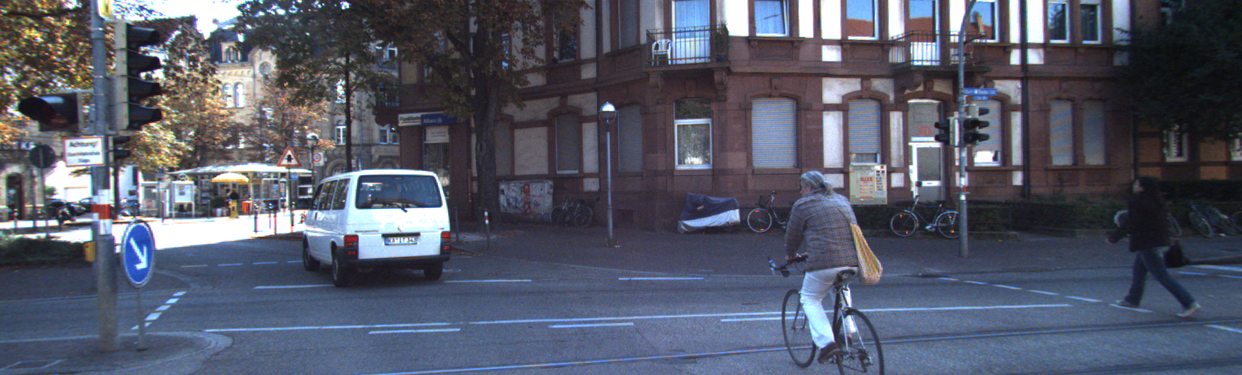

In [36]:
data.get_rgb(0)[0]

array([[1443.0754,    0.    , 1219.1186],
       [   0.    , 1443.0754,  345.708 ],
       [   0.    ,    0.    ,    2.    ]])